In [1]:
from templates import *

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: saranga7. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /users/biocomp/mahanta/.netrc


#### Branch saranga

In [33]:
device = 'cuda:0'
conf = ffhq128_autoenc_w_classifier()
conf.include_classifier = False
# conf.name = 'ffhq128_autoenc_w_classifier_weightedLoss_step_BN'
conf.name = 'ffhq128_w_newclassifier2'
# print(conf.name)
model = LitModel(conf)
# state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
state = torch.load(f'checkpoints/{conf.name}/epoch_checkpoints/epoch=159-step=43679.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device)
model.model.eval()
model.model.to(device)

Global seed set to 0
Using cache found in /users/biocomp/mahanta/.cache/torch/hub/pytorch_vision_v0.10.0


Model params: 124.96 M


BeatGANsAutoencModel(
  (time_embed): TimeStyleSeperateEmbed(
    (time_embed): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (style): Identity()
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=256, bias=True)
        )
        (cond_emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=128, bias

In [34]:
data = ImageDataset('imgs_align', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch = data[1]['img'][None]

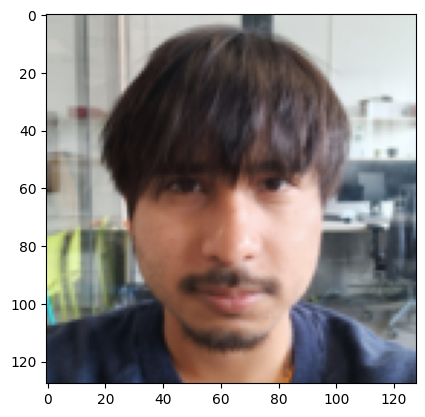

In [35]:
import matplotlib.pyplot as plt
plt.imshow(batch[0].permute([1, 2, 0]) / 2 + 0.5)

# Encode

In [36]:
cond = model.encode(batch.to(device), mode = 'non_ema')
xT = model.encode_stochastic(batch.to(device), cond, T=100, mode = 'non_ema')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.0576506..6.6022067].


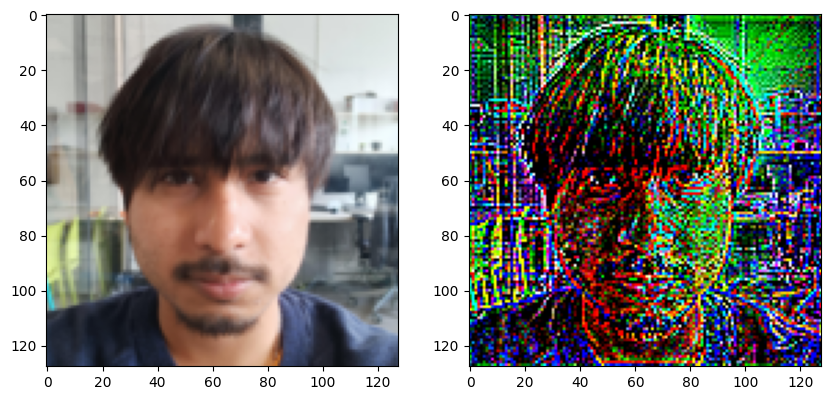

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

# Decode

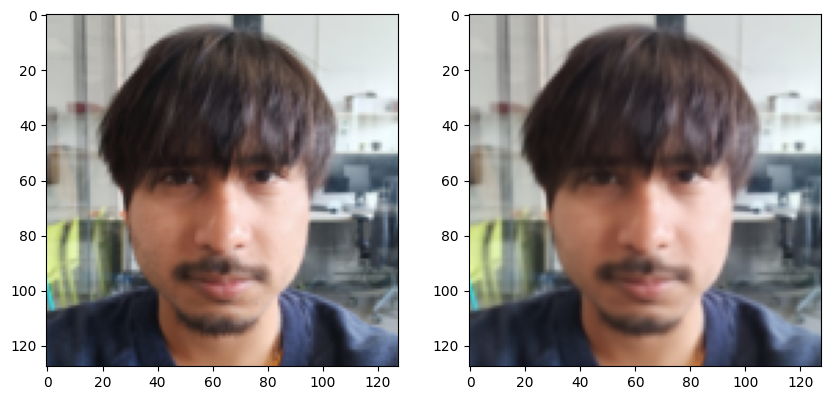

In [38]:
pred = model.render(xT, cond, T=100, mode = 'non_ema')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(pred[0].permute(1, 2, 0).cpu())

In [39]:
xT2 = torch.randn_like(xT)

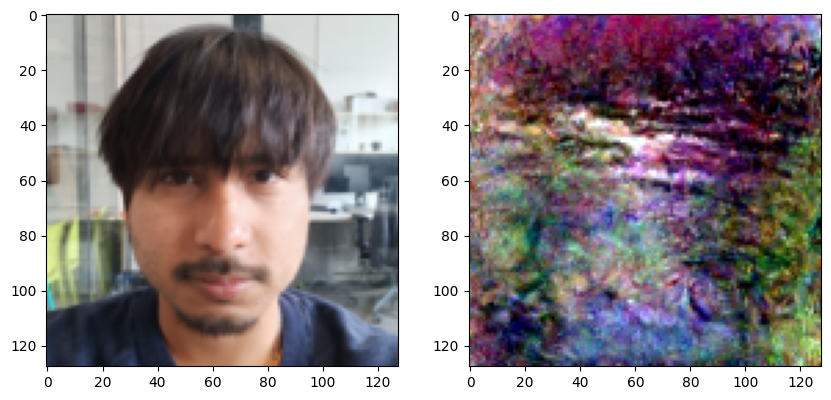

In [40]:
pred = model.render(xT2, cond, T=100, mode = 'non_ema')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(pred[0].permute(1, 2, 0).cpu())

# Decode with class_concatenated cond

In [44]:
cond = model.encode(batch.to(device), mode = 'non_ema')
modified_cond = model.model.classifier_component(x = batch.to(device), cond = cond)
modified_xT = model.encode_stochastic(batch.to(device), modified_cond, T=100, mode = 'non_ema')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.1307807..6.8035254].


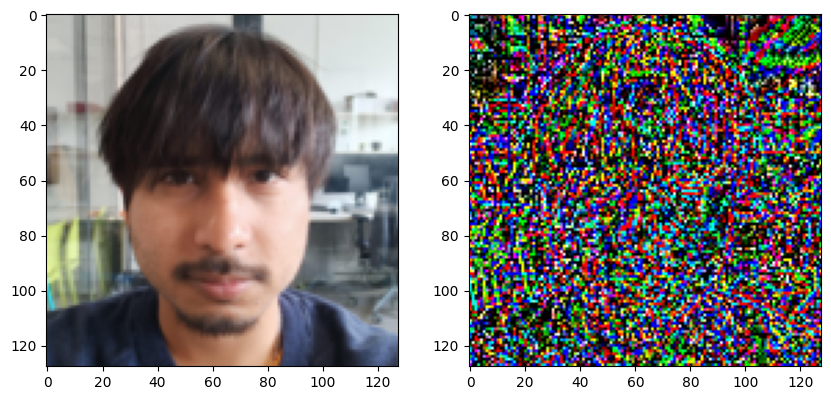

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(modified_xT[0].permute(1, 2, 0).cpu())

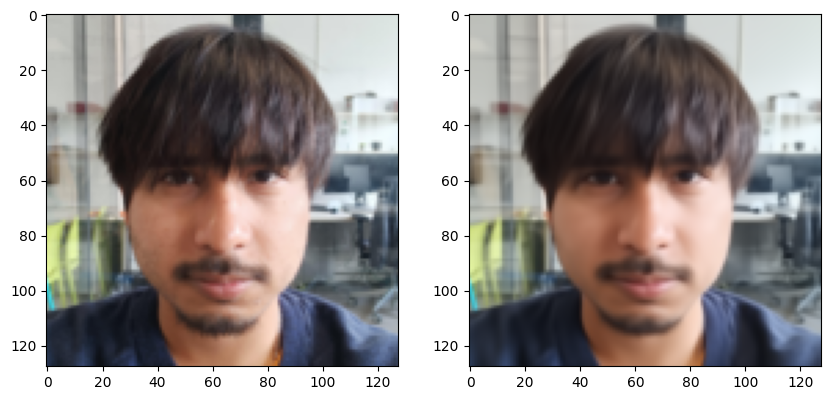

In [46]:
pred = model.render(modified_xT, modified_cond, T = 100, mode = 'non_ema')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(pred[0].permute(1, 2, 0).cpu())

In [47]:
xT_random = torch.randn_like(modified_xT)

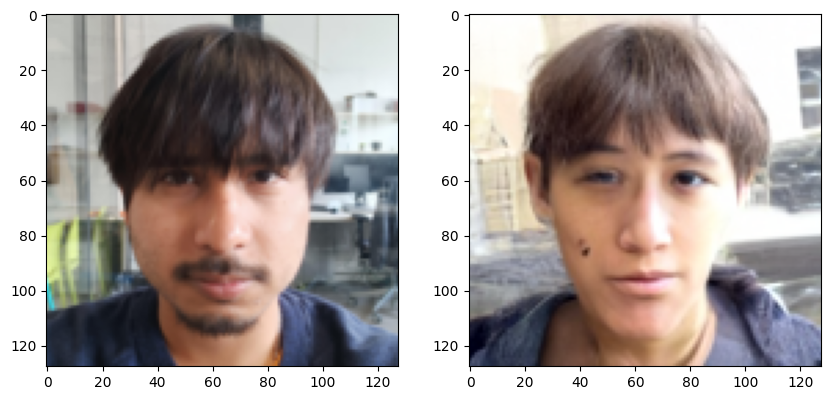

In [48]:
pred = model.render(xT_random, modified_cond, T = 100, mode = 'non_ema')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(pred[0].permute(1, 2, 0).cpu())

# Decode with class_concatendated cond (flip classifier)

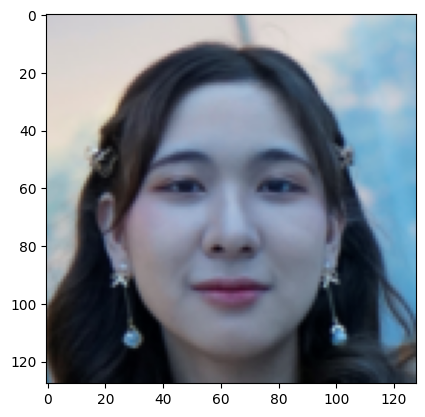

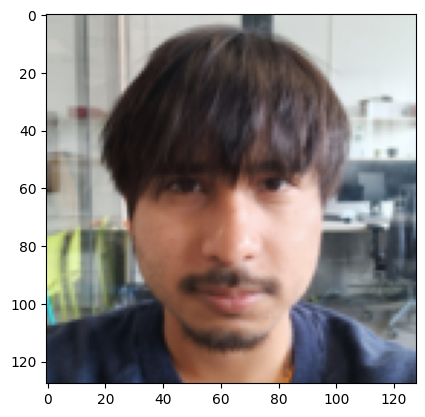

In [49]:
sandy_img = data[0]['img'][None]
plt.imshow(sandy_img[0].permute([1, 2, 0]) / 2 + 0.5)
plt.show()

saranga_img = data[1]['img'][None]
plt.imshow(saranga_img[0].permute([1, 2, 0]) / 2 + 0.5)
plt.show()

In [56]:
def flip_class(ip_img, opp_gender_img, encoding_T = 100, rendering_T = 100):
    cond = model.encode(ip_img.to(device))
    cond_ip = model.model.classifier_component(x = ip_img.to(device), cond = cond)

    c_opp = model.model.classifier_component.mobile_net(opp_gender_img.to(device))
    c_opp = F.softmax(c_opp, dim = 1)

    c_ip = model.model.classifier_component.mobile_net(ip_img.to(device))
    c_ip = F.softmax(c_ip, dim = 1)


    # taking classifier output of sandy and concatenating that to cond
    cond_class = torch.cat([c_opp, cond], axis = 1)
    modified_cond = model.model.classifier_component.linear_projection(cond_class)

    print("Encoding stochastic...")
    modified_xT = model.encode_stochastic(ip_img.to(device), cond_ip, T = encoding_T, mode = 'non_ema')

    print("Generating results...")
    pred = model.render(modified_xT, modified_cond, T = rendering_T, mode = 'non_ema')

    # print("Using DDIM inverted X_T:")
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ori = (ip_img + 1) / 2
    ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
    ax[1].imshow(pred[0].permute(1, 2, 0).cpu())
    # plt.title("Using DDIM inverted X_T")
    plt.show()

    # pred = model.render(torch.randn_like(modified_xT), modified_cond, T = rendering_T, mode = 'non_ema')
    # # print("Using random X_T:")
    # fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    # ori = (ip_img + 1) / 2
    # ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
    # ax[1].imshow(pred[0].permute(1, 2, 0).cpu())
    # plt.title("Using random X_T")
    # plt.show()


Encoding stochastic...
Generating results...


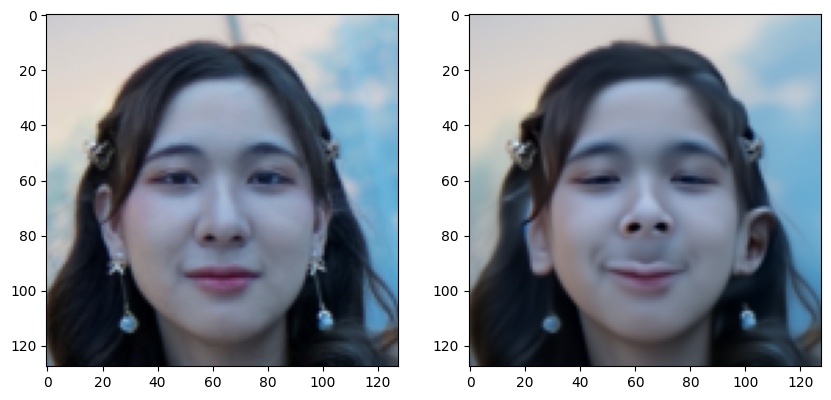

In [57]:
flip_class(sandy_img, saranga_img)

Encoding stochastic...
Generating results...


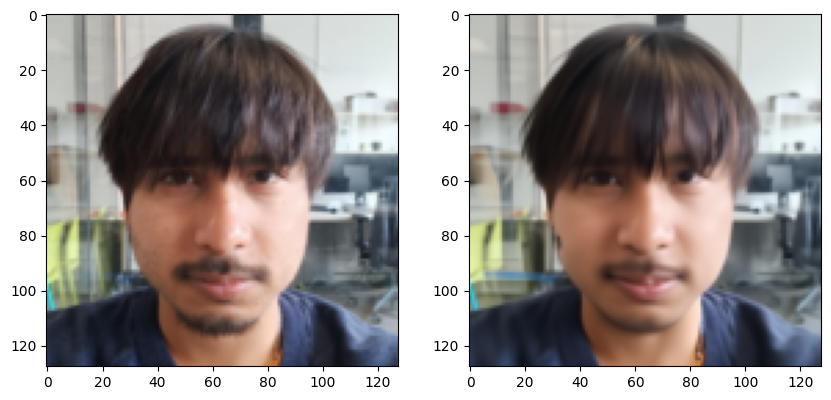

In [58]:
flip_class(saranga_img, sandy_img)

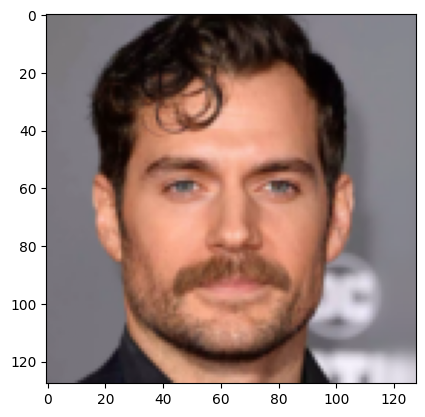

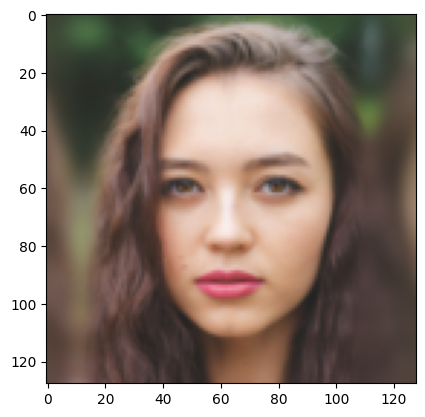

In [59]:
male =  data[5]['img'][None]
plt.imshow(male[0].permute([1, 2, 0]) / 2 + 0.5)
plt.show()

female = data[10]['img'][None]
plt.imshow(female[0].permute([1, 2, 0]) / 2 + 0.5)
plt.show()

Encoding stochastic...
Generating results...


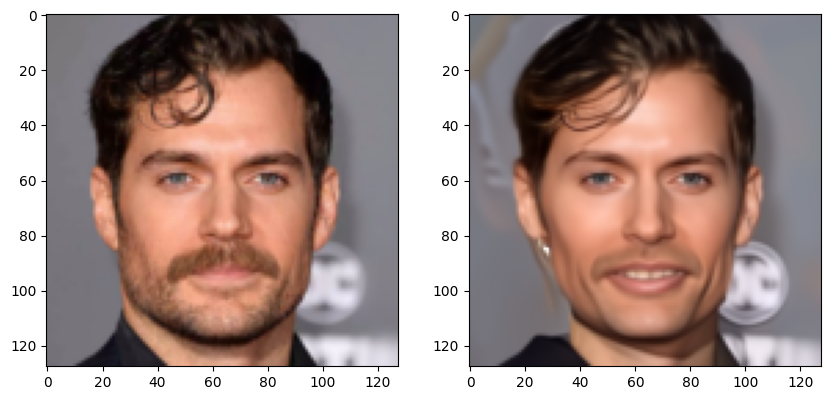

In [60]:
flip_class(male, female)

Encoding stochastic...
Generating results...


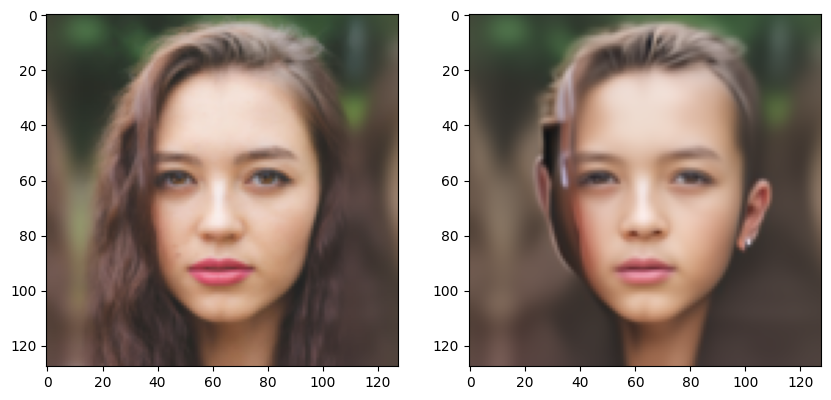

In [62]:
flip_class(female, male)

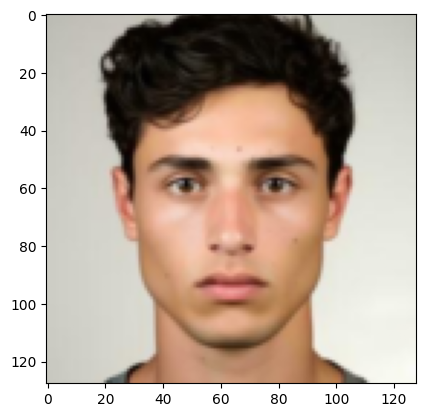

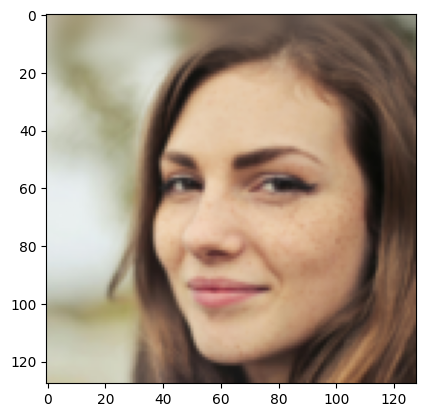

In [63]:
male =  data[3]['img'][None]
plt.imshow(male[0].permute([1, 2, 0]) / 2 + 0.5)
plt.show()

female = data[11]['img'][None]
plt.imshow(female[0].permute([1, 2, 0]) / 2 + 0.5)
plt.show()

Encoding stochastic...
Generating results...


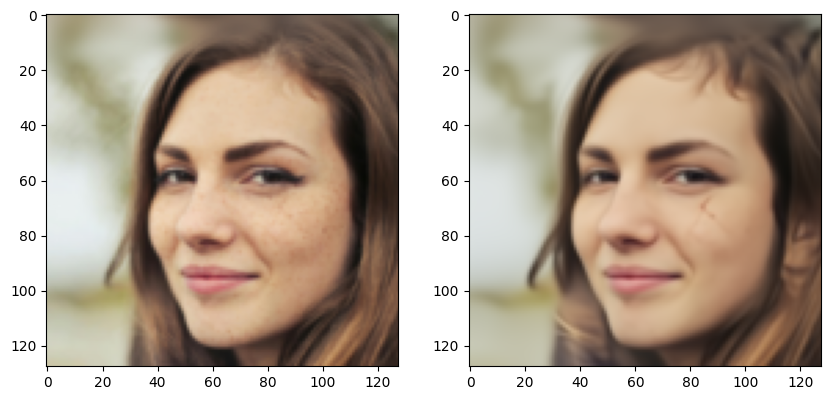

In [64]:
flip_class(female, male)

Encoding stochastic...
Generating results...


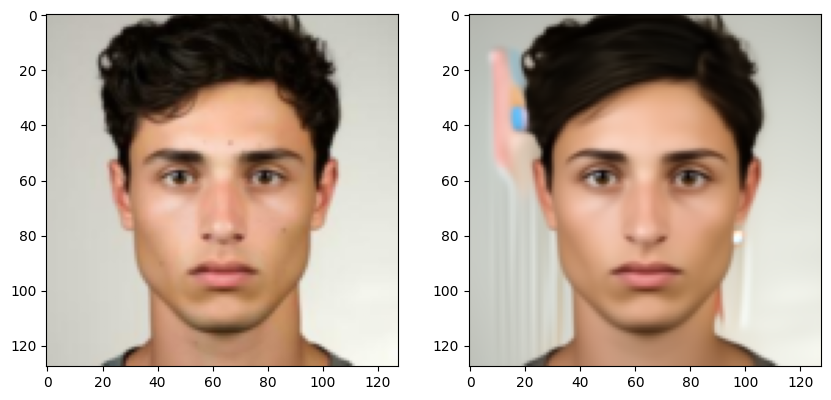

In [65]:
flip_class(male, female)